<a href="https://colab.research.google.com/github/tejasvi541/Machine-Learning/blob/main/FlowersClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

1. Pick a dataset
2. Download a dataset
3. Import dataset using pytorch
4. Explore the dataset
5. Build the model

In [ ]:
# pip Installing opendatasets
!pip install opendatasets --upgrade

### Using OpenDataset to download data at https://www.kaggle.com/alxmamaev/flowers-recognition

In [ ]:
import opendatasets as od
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [ ]:
dataset_url = "https://www.kaggle.com/alxmamaev/flowers-recognition"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tejasvii
Your Kaggle Key: ··········


  0%|          | 0.00/450M [00:00<?, ?B/s]

100%|██████████| 450M/450M [00:04<00:00, 98.3MB/s]


In [ ]:
data_dir = "./flowers-recognition/flowers"

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['tulip', 'rose', 'flowers', 'sunflower', 'dandelion', 'daisy']

In [ ]:
# Deleting the extra flowers directory
import shutil
shutil.rmtree(data_dir + "/flowers")

In [ ]:
os.listdir(data_dir)

['tulip', 'rose', 'sunflower', 'dandelion', 'daisy']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + "/"+ cls)))

tulip 984
rose 784
sunflower 734
dandelion 1055
daisy 769


### Importing Data

Use the `ImageFolder class` from `torchvision`

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

4323

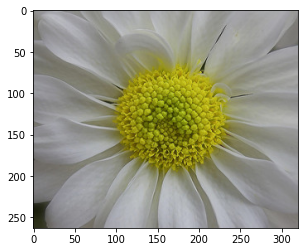

In [ ]:
# Visualising images
image, label = dataset[0]
plt.imshow(image)
# print(label)

In [ ]:
# Using transforms to convert image to tensors

dataset = ImageFolder(data_dir, tt.Compose([
                                            tt.Resize(224),
                                            tt.RandomCrop(224),
                                            tt.ToTensor(),
]))

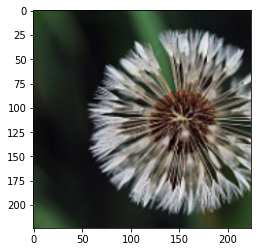

In [ ]:
image, label = dataset[1220]
plt.imshow(image.permute(1,2,0))


Slicing the dataset into train and test

In [ ]:
val_pct = 0.1   # Validation Percecntage
val_size = int(val_pct * len(dataset))

train_size = len(dataset) - val_size
val_size,train_size

(432, 3891)

In [ ]:
from torch.utils.data import random_split

train_ds,  valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [ ]:
# Importing Dataloaders to work with data and batch sizes
batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers = 3,
                      pin_memory = True)

val_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers = 3,
                      pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Showing a batch of data

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (20,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


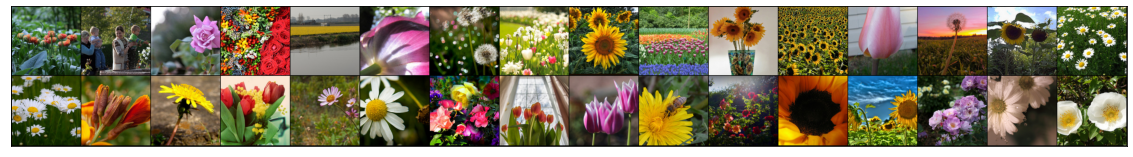

In [ ]:
show_batch(train_dl)

## Utility funtions and Classes

In [ ]:
## GPU utilities
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Model Training Utilites

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([32, 3, 224, 224])
images.device cuda:0
preds.shape torch.Size([32, 5])


## Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1830357164144516, 'val_loss': 1.611870527267456}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3751, val_loss: 0.9743, val_acc: 0.6272
Epoch [1], train_loss: 1.0315, val_loss: 0.8956, val_acc: 0.6429
Epoch [2], train_loss: 0.9031, val_loss: 0.9368, val_acc: 0.6562
Epoch [3], train_loss: 0.8572, val_loss: 0.8418, val_acc: 0.7009
Epoch [4], train_loss: 0.7527, val_loss: 1.2809, val_acc: 0.5179


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8617, val_loss: 0.9256, val_acc: 0.6964
Epoch [1], train_loss: 0.7276, val_loss: 0.6611, val_acc: 0.7746
Epoch [2], train_loss: 0.6461, val_loss: 1.1513, val_acc: 0.6473
Epoch [3], train_loss: 0.6340, val_loss: 0.6254, val_acc: 0.7857
Epoch [4], train_loss: 0.5551, val_loss: 0.8203, val_acc: 0.7054


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4184, val_loss: 0.5194, val_acc: 0.8125
Epoch [1], train_loss: 0.3902, val_loss: 0.4516, val_acc: 0.8393
Epoch [2], train_loss: 0.3476, val_loss: 0.4884, val_acc: 0.8438
Epoch [3], train_loss: 0.3411, val_loss: 0.4554, val_acc: 0.8393
Epoch [4], train_loss: 0.3435, val_loss: 0.4588, val_acc: 0.8393


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.3087, val_loss: 0.4521, val_acc: 0.8304
Epoch [1], train_loss: 0.3203, val_loss: 0.4598, val_acc: 0.8348
Epoch [2], train_loss: 0.3153, val_loss: 0.4440, val_acc: 0.8348
Epoch [3], train_loss: 0.3178, val_loss: 0.4627, val_acc: 0.8304
Epoch [4], train_loss: 0.3140, val_loss: 0.4415, val_acc: 0.8281


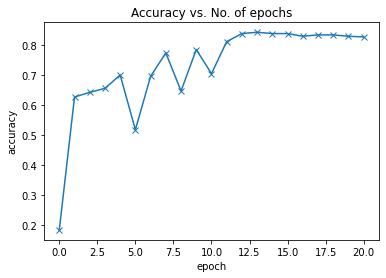

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

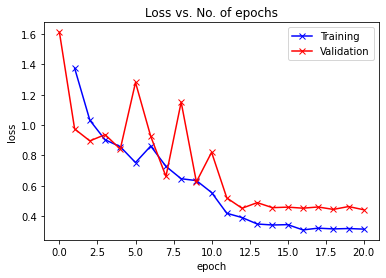

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

In [ ]:
history[-1]

{'train_loss': 0.3139525055885315,
 'val_acc': 0.828125,
 'val_loss': 0.4415213465690613}

## Testing with individual images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


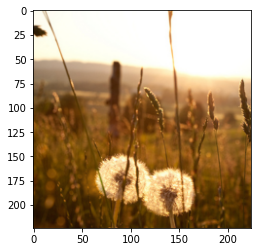

In [ ]:
show_image_prediction(*valid_ds[100])

Target: dandelion
Prediction: dandelion


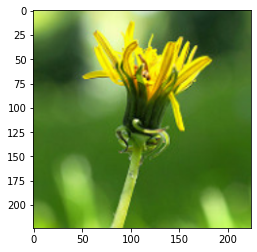

In [ ]:
show_image_prediction(*valid_ds[300])

Target: rose
Prediction: rose


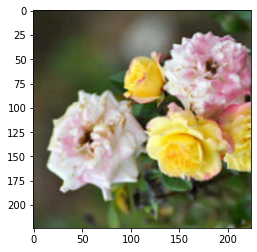

In [ ]:
show_image_prediction(*valid_ds[12])